# Unsupervised Domain Adaptation

이번 시간에는 Unsupervised Domain Adaptation 모델을 구현해봅니다.

Unsupervised Domain Adaptation이란 Source Domain에 대한 label이 있고, Target Domain에 대한 label이 없는 Unsupervised Learning 상황에서 Domain Adaptation을 수행하는 것을 말합니다.



# Domain-Adversarial Training of Neural Networks (DANN)
 > Unsupervised Domain Adaptation by Backpropagation (https://arxiv.org/abs/1409.7495)


## Overview

<img src='https://miro.medium.com/v2/resize:fit:1400/format:webp/1*9aVg6JGcZFSKHUn_U4RrUQ.png'>


* DANN은 Adversarial Training을 이용한 Domain Adaptation 방법론입니다.
   - 도메인이 달라지더라도 충분히 일반화할 수 있도록 모델을 학습하는 것이 목적입니다.
   - GAN의 아이디어의 착안하여, feature extractor와 domain classifier가 경쟁적으로 학습하도록 합니다.

* 모델 구조는 feature extractor, label predictor, domain classifier로 나누어집니다.
   - classification loss와 domain confusion loss(domain clasification loss) 두 가지로 모델을 학습합니다.
   - domain confusion loss는 source dataset과 target dataset의 domain을 구별하지 못하도록 모델을 혼동시켜 source domain과 target domain의 feature distribution을 일치시키고자 합니다.
   - 따라서 source와 target의 feature distributions이 일치하는 방향으로 학습되게 하기 위해  classification loss는 최소화하는 한편, domain confusion loss를 최대화하고자 합니다.
   - Domain confusion loss를 최대화하기 위해서 gradient reversal layer를 사용합니다.





In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

In [ ]:
# basic random seed
import os
import random
import numpy as np

random_seed= 2023

def seedBasic(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# torch random seed
import torch
def seedTorch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# basic + torch
def seedEverything(seed):
    seedBasic(seed)
    seedTorch(seed)
    print(f"Ransom Seed: {seed}")


seedEverything(2023)

Ransom Seed: 2023


## 데이터셋 불러오기: MNIST, MNIST-M

Source Dataset으로 MNIST, Target Datset으로 MNIST-M을 사용합니다.
- MNIST 데이터셋은 손으로 쓴 숫자들로 이루어진 데이터셋입니다.
- 반면에, MNIST-M은 BSDS500 데이터셋의 컬러 사진에서 무작위로 추출한 패치를 배경으로 MNIST 숫자와 결합하여 생성한 데이터셋입니다.

  <img src='https://ifh.cc/g/MRy7xc.png'>

### 데이터셋 다운받기
먼저 사용할 데이터셋을 불러옵니다.

- MNIST dataset은 Torchvision에서 built-in dataset으로 사용할 수 있으며, MNIST-M 데이터셋은 아래의 링크에서 다운받을 수 있습니다.

 (ref: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html)

In [ ]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2023-08-18 04:23:13--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.60K  --.-KB/s    in 0s      

2023-08-18 04:23:13 (64.3 MB/s) - ‘mnistm.py’ saved [2659/2659]



In [ ]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


100%|██████████| 9912422/9912422 [00:00<00:00, 71051737.84it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22562058.82it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20627395.84it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4299374.58it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/content/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Building train set...
Processing example 0
Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


다운받은 pickle로 직렬화된 데이터셋을 로드해줍니다.

In [ ]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

다음으로 MNIST dataset을 torchvision.datasets 모듈을 통해 불러옵니다.

데이터셋을 불러올 때 전달하는 각 인자가 의미하는 바는 다음과 같습니다.
- root : 데이터의 경로입니다.
- train : test 데이터를 가져올지 train 데이터를 가져올지 표시합니다. True면 train용 데이터를 가져옵니다.
- transform : 어떤 형태로 데이터를 불러올 것인가를 결정합니다. 일반 이미지는 0-255사이의 값을 갖고, (H, W, C)의 형태를 갖는 반면,  pytorch는 0-1사이의 값을 가지고 (C, H, W)의 형태를 갖습니다. transform에 transforms.ToTensor()를 넣어서 일반 이미지(PIL image)를 pytorch tensor로 변환할 수 있습니다.

- download : True로 설정하면 MNIST 데이터가 있는지 확인하고 없다면 데이터를 다운 받습니다.

In [ ]:
mnist_train =  torchvision.datasets.MNIST(root='.',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test =  torchvision.datasets.MNIST(root='.',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

###  데이터셋 살펴보기
다음으로 사용할 데이터셋의 특징을 살펴보겠습니다.

데이터셋이 어떤 이미지로 구성되어있는지 시각화를 통해 확인해봅니다.

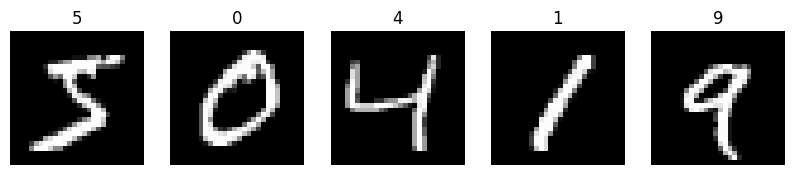

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = (x * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

MNIST-M 데이터셋에 대해서도 마찬가지로 시각화를 통해 데이터를 살펴봅시다.

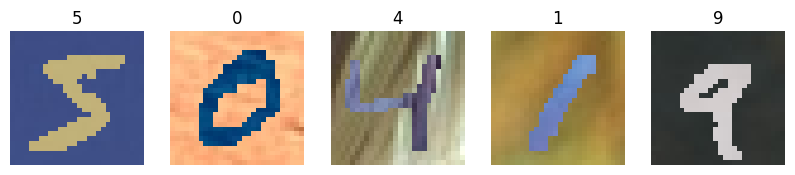

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_m['x_train'][i], mnist_m['y_train'][i]
  plt.imshow(x)
  plt.title(y)


다음으로 MNIST 데이터셋의 평균 및 표준 편차를 계산합니다.

이 값을 사용하여 MNIST와 MNIST-M을 모두 표준화(standardization)할 수 있습니다.

In [ ]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


## 데이터셋 및 데이터로더 생성하기

표준화를 포함하여 transform을 다시 구성하여 데이터셋을 재정의 해줍니다.

<br>

이때, 한 가지 더 고려할 것이 있습니다.

**MNIST-M**은 MNIST와 매우 비슷해보이지만,

MNIST는 gray-scale의 이미지, MNIST-M은 색상과 질감을 가지고 있는 RGB 이미지라는 차이점을 갖고 있습니다.


즉, MNIST는 1채널 데이터셋인 반면, MNIST-M 데이터셋은 3채널의 데이터셋입니다.


<br>


따라서 transform 과정에서 채널 축의 세 배를 복제해줍니다.

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

MNIST에 대한 Dataloader를 생성합니다.

In [ ]:
source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

마찬가지로 MNIST-M dataset도 dataloader를 만들어줍니다.

<br>


먼저, torch dataset 형태로 dataset을 정의합니다.

In [ ]:
class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

정의한 dataset을 바탕으로 dataloader를 생성합니다.

In [ ]:
target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

## 기본 모델 구현하기


이제, 기본적인 네트워크를 구현해 보겠습니다.

다음의 그림을 참고하여 #TODO를 채워 모델을 구현합니다.

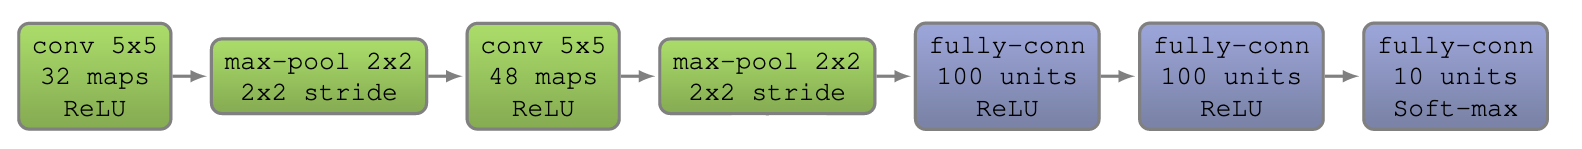

### 모델 정의

In [ ]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()

    # TODO
    ##################
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 48, kernel_size=5),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Output Size = (I - K ) + 1
    # (I - K )/2+ 1

    # 1: 28 - 5 + 1. = 24
    # 2: (24 - 2)/2 + 1 = 12
    # 3: 12 - 5 + 1 = 8
    # 4: (8 - 2)/2 + 1 = 4

    self.classif = nn.Sequential(
        nn.Linear(48*4*4, 100),
        nn.ReLU(True),
        nn.Linear(100, 100),
        nn.ReLU(True),
        nn.Linear(100, 10),
        nn.Softmax()
    )
    ##################

  def forward(self, x):
    # TODO
    ##################
    x = self.cnn(x)
    x = x.view(-1, 48 * 4 * 4)
    # x = x.view(-1, 48*4*4)
    # x = x.reshape(-1, 48*4*4) # reshape() == contiguous().view()
    # x = x.flatten(start_dim=1, end_dim=3)
    x = self.classif(x)
    ##################
    return x


NaiveNet()(torch.randn(2, 3, 28, 28)).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([2, 10])

### 모델 평가 코드

In [ ]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

### 모델 학습


구현한 naive model을 바탕으로 source dataset인 MNIST에 대해서만 모델을 훈련시킵니다.


모델 학습 과정에서 **learning rate scheduler**을 사용하여 각 epoch 후에 *lambda*로 정의된 함수에 따라 학습률을 업데이트 합니다.

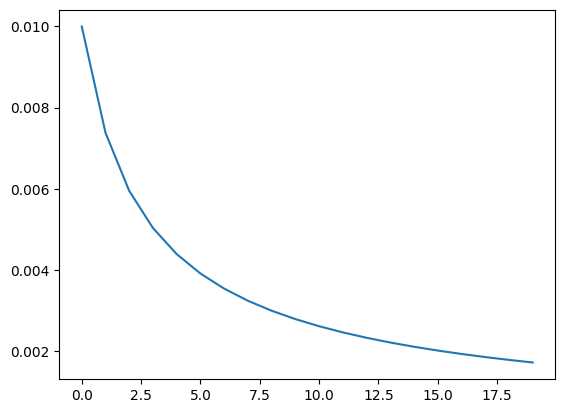

In [ ]:
epochs = 20

mu0, alpha, beta = 0.01, 10, 0.75

x = [i for i in range(epochs)]
lmbd = lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
y = [lmbd(i) for i in range(epochs)]

plt.plot(x, y)

In [ ]:
seedEverything(2023)

epochs = 20

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Ransom Seed: 2023
Epoch 0, train loss: 1.94536
	Learning rate = 0.007377879464668811
Epoch 1, train loss: 1.58323
	Learning rate = 0.005946035575013606
Epoch 2, train loss: 1.50545
	Learning rate = 0.005029733718731742
Epoch 3, train loss: 1.49463
	Learning rate = 0.004386913376508308
Epoch 4, train loss: 1.48961
	Learning rate = 0.003907949713906801
Epoch 5, train loss: 1.48659
	Learning rate = 0.0035355339059327372
Epoch 6, train loss: 1.48434
	Learning rate = 0.0032366118113821563
Epoch 7, train loss: 1.48242
	Learning rate = 0.002990697562442441
Epoch 8, train loss: 1.48093
	Learning rate = 0.00278437664873526
Epoch 9, train loss: 1.47987
	Learning rate = 0.0026084743001221454
Epoch 10, train loss: 1.47902
	Learning rate = 0.0024564898981344154
Epoch 11, train loss: 1.47829
	Learning rate = 0.002323680802425408
Epoch 12, train loss: 1.47764
	Learning rate = 0.0022065006130979154
Epoch 13, train loss: 1.47707
	Learning rate = 0.0021022410381342864
Epoch 14, train loss: 1.47653
	Lear

### 모델 평가


10 epoch에서 MNIST에 대한 모델 성능은 90% 이상의 정확도를 가지고 있습니다.

하지만 학습된 모델이 약간 다른 도메인을 가진 MNIST-M에서도 일반화된 성능을 보여줄까요?

In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 1.97368, test acc: 47.41


Target dataset에서 naive model의 정확도는 40~50% 정도로 source dataset 보다 훨씬 낮은 것을 볼 수 있습니다.

## DANN 구현하기


이제 **DANN**(**Domain Adverserial Neural Network**)을 구현해봅니다.

모델의 핵심 파트는 domain prediction branch와 **gradient reversal layer**(GRL)입니다.

* GRL은 domain classifier(분홍색)와 features extractor(녹색) 사이의 기울기가 반대로 되도록 만들어줍니다.

* domain classifier의 기울기는 도메인을 더 잘 분류하는 데 도움이 됩니다.
 * 따라서 features extractor가 끝나기 전에 기울기를 반대로 되돌린다면, CNN이 domain을 잘 구분하지 못하는 방향으로 학습될 수 있습니다.

* 즉, MNIST와 MNIST-M의 feature는 유사해지면서, classification을 위한 숫자 정보는 유지될 수 있습니다.

PyTorch에서 기울기가 역방향이 되도록 하려면 **'torch.autograd.Function'**를 정의해야 합니다.

forward의 경우 backward를 위해 필요한 factor를 저장합니다.



In [ ]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors
    # TODO
    ##################
    reversed_grad = grad*factor
    ##################
    return reversed_grad, None

In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


이제 DANN 코드를 작성합니다.

<br>

기본 모델과 마찬가지로, 다음의 그림을 참고하여 #TODO를 채워 모델을 구현해봅시다.

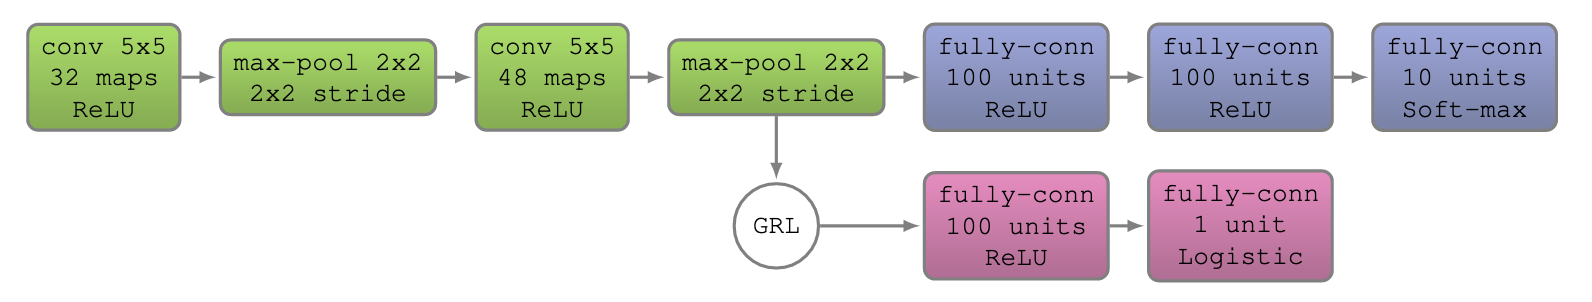

In [ ]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()

    # TODO
    ##################
    self.cnn = nn.Sequential()
    self.cnn.add_module("f_conv1", nn.Conv2d(3, 32, kernel_size=5))
    self.cnn.add_module("f_relu1", nn.ReLU())
    self.cnn.add_module("f_pool1", nn.MaxPool2d(kernel_size=2, stride=2))
    self.cnn.add_module("f_conv2", nn.Conv2d(32, 48, kernel_size=5))
    self.cnn.add_module("f_relu2", nn.ReLU())
    self.cnn.add_module("f_pool2", nn.MaxPool2d(kernel_size=2, stride=2))


    self.classif = nn.Sequential()
    self.classif.add_module("c_fc1", nn.Linear(48*4*4, 100))
    self.classif.add_module("c_relu1", nn.ReLU())
    self.classif.add_module("c_fc2", nn.Linear(100, 100))
    self.classif.add_module("c_relu2", nn.ReLU())
    self.classif.add_module("c_fc3", nn.Linear(100, 10))
    self.classif.add_module("c_softmax", nn.Softmax())

    self.domain = nn.Sequential()
    self.domain.add_module("d_fc1", nn.Linear(48*4*4, 100))
    self.domain.add_module("d_relu1", nn.ReLU())
    self.domain.add_module("d_fc2", nn.Linear(100, 1))
    ##################

  def forward(self, x, factor=1):
    # TODO
    ##################
    x = self.cnn(x)
    x = x.reshape(-1, 48*4*4)
    class_pred = self.classif(x)
    x = GradientReversal.apply(x, -factor)
    domain_pred = self.domain(x)
    ##################
    return class_pred, domain_pred


In [ ]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [ ]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

GRL의 경우 factor로 -1을 직접 사용하면 성능이 매우 저하됩니다.

따라서 훈련 중에 점차 factor을 증가시켜야합니다.

사용할 함수의 plot을 그려봅니다.

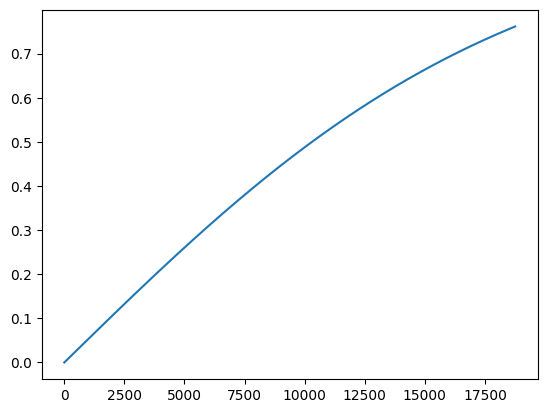

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


이제 DANN을 학습시켜봅시다.

GRL factor는 각 배치 후에 업데이트됩니다.

다음의 코드에서 #TODO를 채워 학습 과정을 구현해봅시다.

이때,MNIST-M의 label은 사용할 수 없다는 것을 유의해주세요.

In [ ]:
seedEverything(2023)

epochs = 20

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    # TODO
    ##################
    sd = torch.ones(len(xs))
    td = torch.zeros(len(xt))
    d = torch.cat((sd, td))
    ##################

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    # TODO
    ##################
    ce = F.cross_entropy(cls_logits[:len(xs)], ys.cuda())
    bce = F.binary_cross_entropy_with_logits(domain_logits[:,0], d.cuda())
    ##################

    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

Ransom Seed: 2023
GRL factor 0.0
Epoch 0, class loss: 1.75861, domain loss: 0.13618
GRL factor 0.049958374957880025
Epoch 1, class loss: 1.50284, domain loss: 0.12746
GRL factor 0.0996679946249559
Epoch 2, class loss: 1.49078, domain loss: 0.12578
GRL factor 0.14888503362331806
Epoch 3, class loss: 1.48639, domain loss: 0.13145
GRL factor 0.197375320224904
Epoch 4, class loss: 1.48774, domain loss: 0.14367
GRL factor 0.2449186624037092
Epoch 5, class loss: 1.48844, domain loss: 0.16928
GRL factor 0.2913126124515908
Epoch 6, class loss: 1.49806, domain loss: 0.20439
GRL factor 0.3363755443363323
Epoch 7, class loss: 1.51874, domain loss: 0.28864
GRL factor 0.379948962255225
Epoch 8, class loss: 1.506, domain loss: 0.22228
GRL factor 0.4218990052500078
Epoch 9, class loss: 1.50313, domain loss: 0.2794
GRL factor 0.4621171572600098
Epoch 10, class loss: 1.512, domain loss: 0.2843
GRL factor 0.5005202111902354
Epoch 11, class loss: 1.49858, domain loss: 0.29629
GRL factor 0.537049566998035

처음 기본 모델에서 MNIST-M에 대한 성능은 ~50%정도로 낮은 성능을 보였습니다.

그런데 놀랍게도 DANN 모델은 MNIST-M의 label을 보지 않고도 70% 이상의 정확도까지 이뤄냈습니다.

이제 features space가 실제로 도메인에 구애받지 않는다는 사실을 시각적으로 확인해 보겠습니다.

# TSNE를 이용한 시각화

먼저, 모델의 임베딩을 추출합니다.

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)


다음으로, 임베딩을 시각화합니다.

<br>

임베딩을 시각화하기 위해서 다양한 방법을 사용할 수 있지만, 이번 실습 시간에는 **TSNE**을 사용하여 시각화를 진행하려고 합니다.

사람은 수백 차원의 공간을 이해할 수 없기 때문에 TSNE를 통해 feature space를 2차원의 공간으로 투영하여 시각적으로 확인해볼 수 있습니다.

그러나 TSNE는 몇 가지 단점을 가지고 있어 주의해야 합니다.
- **매우 느립니다**. 따라서 데이터의 하위 집합을 기반으로 계산합니다.
- **결정론적인 모델**이 아닙니다. 따라서 파라미터에 따라 매번 다른 결과를 얻을 수 있습니다.
- **조정할 수 있습니다**. 실제 데이터를 제대로 대표하지 않으면서 원하는 측면을 "*강제"할 수 있습니다

<br>

TSNE에 대한 더 자세하게 알고 싶으시다면 다음 링크를 참고하세요 https://distill.pub/2016/misread-tsne/

In [ ]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

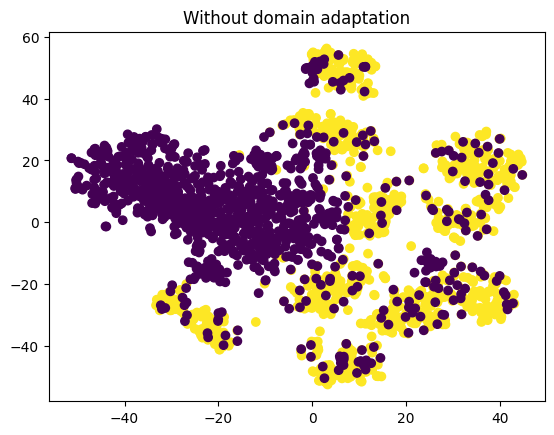

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")


노란색 점은 source dataset(MNIST)이고 보라색 점은 target dataset(MNIST-M)입니다.

naive model을 사용하면 두 데이터가 다른 공간에 속한다는 것을 분명히 알 수 있습니다.

Original embeddings of source / target (60000, 768) (60000, 768)
Samples embeddings (2000, 768) (2000,)
Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

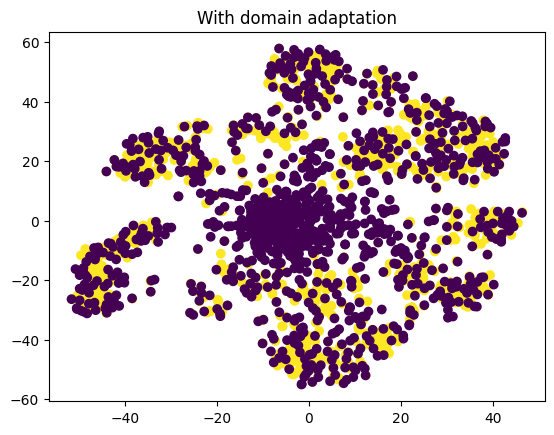

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

DANN을 통해 얻은 임베딩을 마찬가지로 시각화해봅니다.

여전히 완벽하진 않지만, 이전보다 두 도메인이 훨씬 더 병합되어 있는 것을 확인할 수 있습니다.

실제 논문에서 MNIST, MNIST-M 데이터에 대해 성능 평가한 결과는 다음과 같습니다.

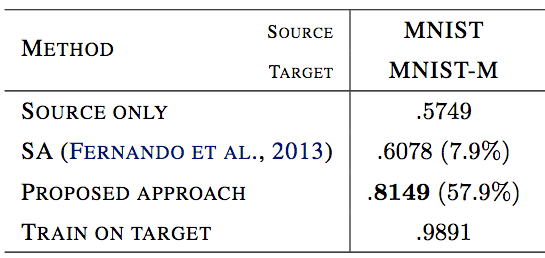

우리가 구현한 모델이 원래 논문에 보고된 성능보다 낮은 것을 알 수 있습니다.

다음 방법들을 통해서 모델 성능을 개선에 도전해봅시다.

- feature extractor(cnn) 구조를 수정
- 훨씬 더 많은 epoch으로 학습
- 단계별로 업데이트할 learning rate scheduler 수정
- 다른 standardization 사용
- 다른  GRL factor scheduling 사용


# Summary

Domain-Adversarial Neural Networks (DANN)
- feature extractor, label classifier, domain classifier로 구성되어 있습니다.
- GAN의 Adversarial Training 방식을 사용합니다.
- feature extractors는 domain classifier를 속여서 도메인을 구별하지 못하는 반면 domain classifier는 기능의 도메인을 정확하게 식별하고자 합니다.
- target domain dataset이 없음에도 불구하고 domain-invariant feature를 생성하여 모델 분류 성능을 높일 수 있다는 장점이 있습니다.
- Minimax game으로 인한 학습 불안정성과 Target domain dataset에 대한 모델의 분류 성능을 오히려 저하시킬 수 있다는 한계를 가집니다.